# Implementing Classification using VGG-1 model

[Reference Tutorial](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [ ]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread
from os import listdir

Loading Images Data
# **H**elicopter vs **P**lane Classification

In [ ]:
train_dir = "/content/drive/MyDrive/ML_Assignment/images/train/"
test_dir = "/content/drive/MyDrive/ML_Assignment/images/test/"
# If using from the GitHub Repo:
# train_dir = "./images/train"
# test_dir = "./images/test"

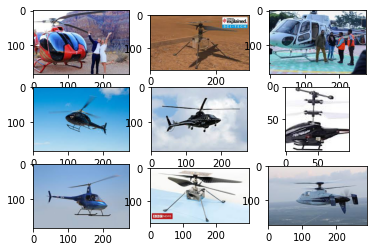

In [ ]:
folder = train_dir + "helicopter/"
lis = listdir(folder)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	filename = folder + lis[-i]
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()

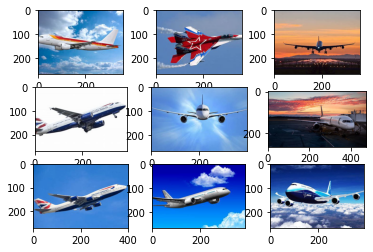

In [ ]:
folder = train_dir + "plane/"
lis = listdir(folder)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	filename = folder + lis[i]
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.legend()
  # plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.legend()
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
	pyplot.close()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness(data_augmentation = False):
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    if (data_augmentation):
      train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
      train_it = train_datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    else:
      train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=25, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print("Accuracy ",'%.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Accuracy  70.000


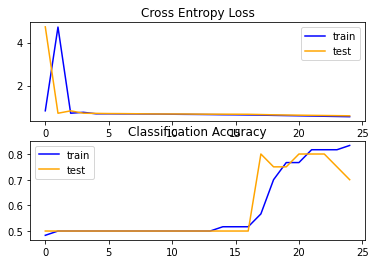

In [ ]:
# Running the test harness without Data Augmentation
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Accuracy  80.000


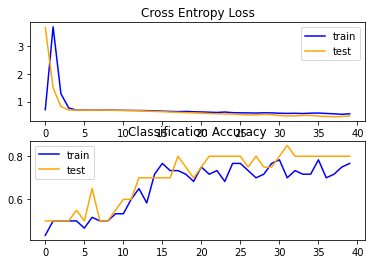

In [ ]:
# Running the test harness with Data Augmentation
run_test_harness(True)

# Transfer learning over the VGG-16 Model!

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model_vgg16():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
def run_test_harness():
	# define model
	model = define_model_vgg16()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=2, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print("Accuracy with Transfer Learning",': %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/2
1/1 [==============================] - 41s 41s/step - loss: 9.4272 - accuracy: 0.3500 - val_loss: 31.0285 - val_accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 45s 45s/step - loss: 19.2157 - accuracy: 0.5000 - val_loss: 0.7636 - val_accuracy: 0.9000
Accuracy with Transfer Learning : 90.000


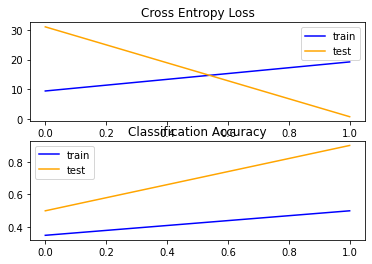

In [ ]:
run_test_harness()